In [1]:
# !pip install nbconvert 
# !jupyter nbconvert model_team14.ipynb --to script

In [94]:
import model_team14 
from model_team14 import select_features, plot_pca, DTW

import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [3]:
metadata=pd.read_csv('../data/full_info.csv')

## select imputed & transformed data
X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
threshold=0.3
criteria=None  
## filtering criteria is not cumulative explained variance ratio but just explained variance ratio


df_feature=select_features(metadata, X, threshold, criteria=criteria)
df_feature[df_feature.select==1]

,PC,variable,var_ratio,var_ratio_cum,group,select,title
0,PC0,IPMANSICS,0.617695,0.617695,1,1,Industrial Production: Manufacturing (SIC)
16,PC0,PAYEMS,0.435164,0.435164,2,1,"All Employees, Total Nonfarm"
47,PC0,HOUST,0.760762,0.760762,3,1,New Privately-Owned Housing Units Started: Tot...
58,PC0,ISRATIOx,0.467138,0.467138,4,1,Total Business: Inventories to Sales Ratio
79,PC0,T10YFFM,0.363146,0.363146,6,1,10-Year Treasury Constant Maturity Minus Feder...
162,PC0,WILL5000INDFC,0.599206,0.599206,8,1,Wilshire 5000 Total Market Full Cap Index
163,PC1,S&P PE ratio,0.335516,0.934722,8,1,S&P's Composite Common Stock: Price-Earnings R...
171,PC0,BSI,0.523465,0.523465,9,1,business survey(manufacturing): Confidence in...


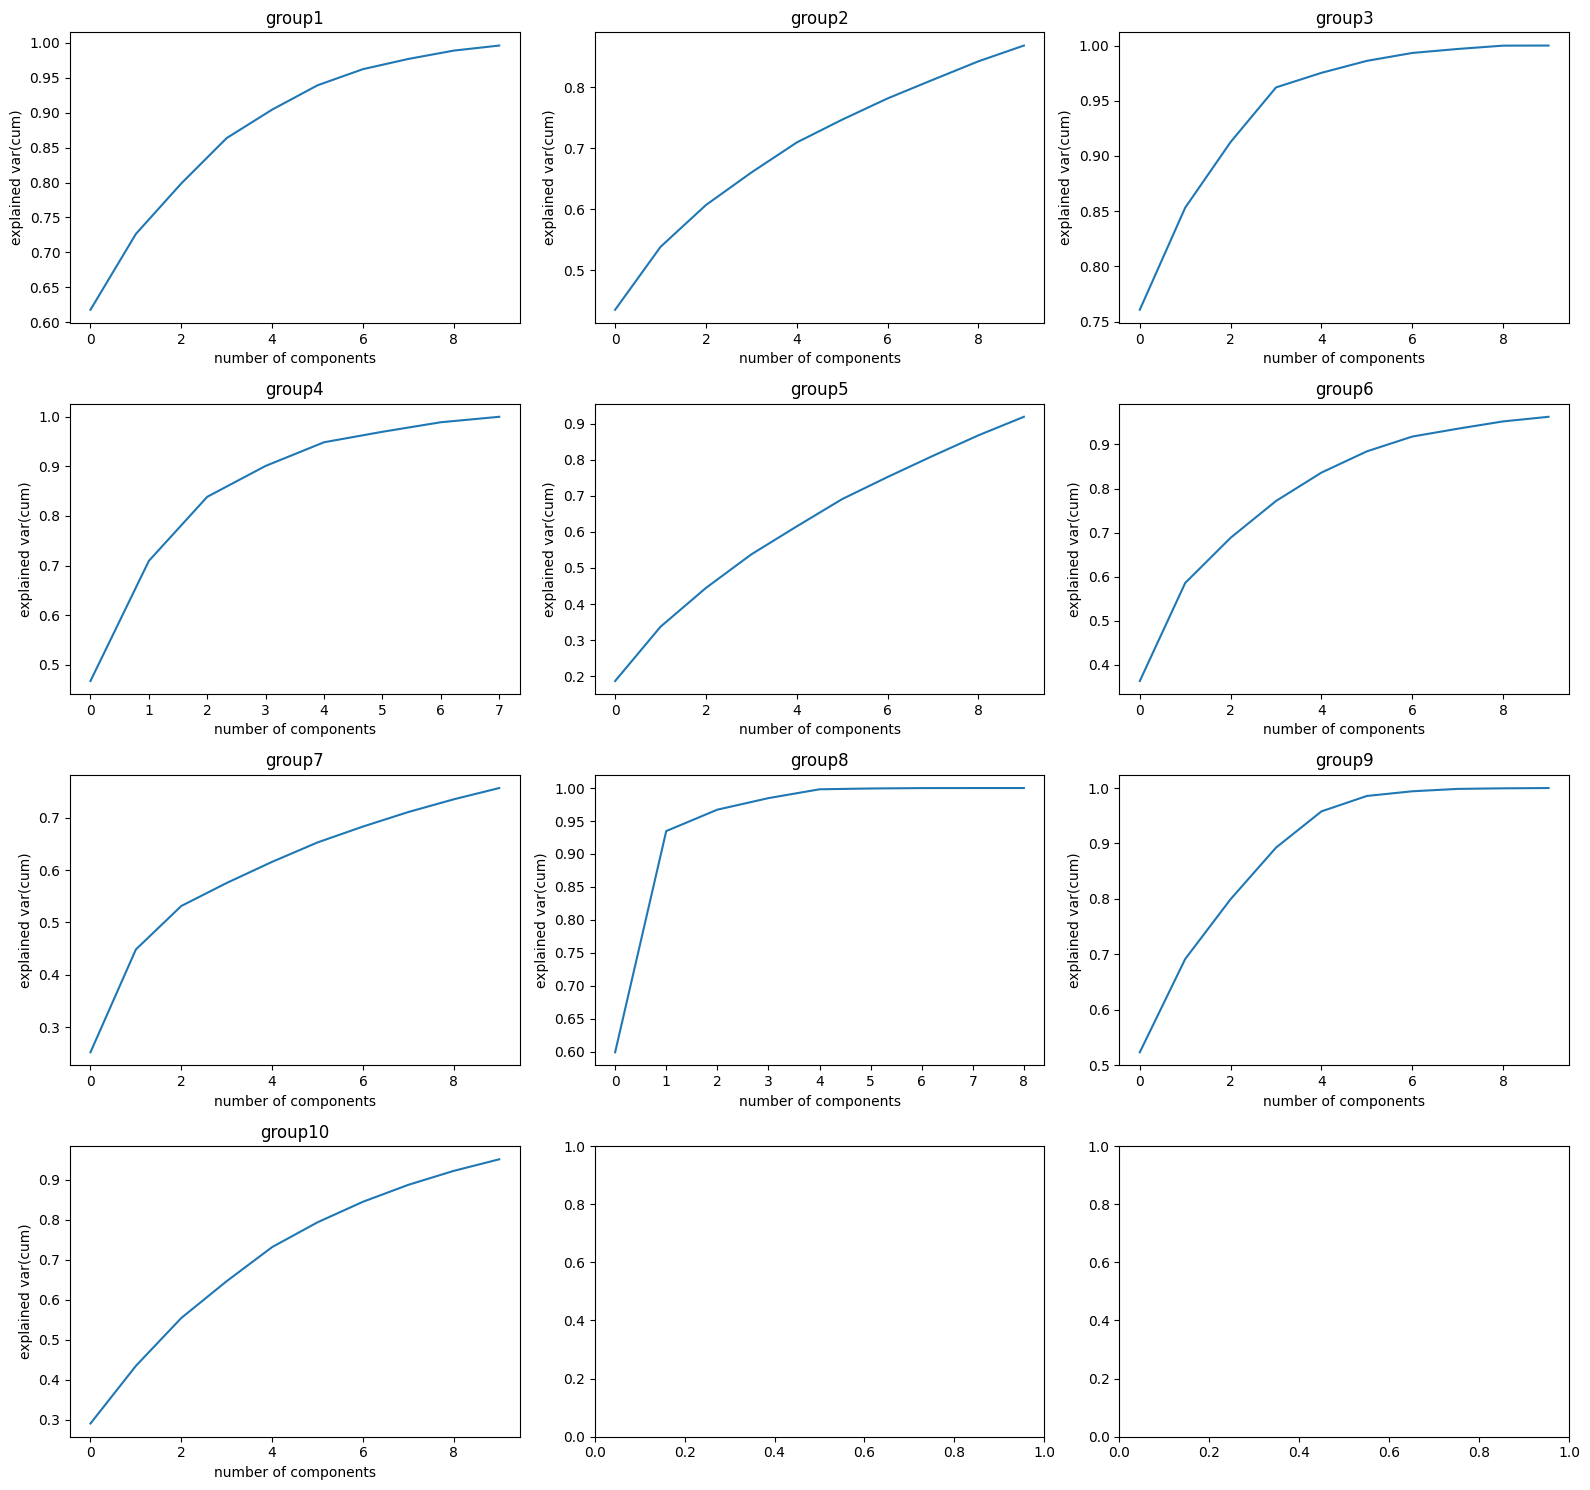

In [4]:
plot_pca(df_feature, metadata)

In [36]:
def knndtw_result(df_feature, param_knn, y_type='y_agg' ,cv='block', test_year=3, n_splits=3, dtype='tr'):
    
    selected_features=list(df_feature[df_feature.select==1]['variable'])

    if dtype=='tr':
        X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
        y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)
    else:
        X=pd.read_csv('../data/X_data.csv', index_col='date', parse_dates=True)
        y=pd.read_csv('../data/y_data.csv', index_col='date', parse_dates=True)
    
    ## train and validation set: X_train, y_train / final test set: X_test, y_test
    X_train=X[selected_features][:-(test_year*12)]  
    y_train=y[y_type][:-(test_year*12)]           
    X_test=X[selected_features][-(test_year*12):]   
    y_test=y[y_type][-(test_year*12):]
    
    ## cross validation for parameter tuning & training
    if cv=='block':
        split=KFold(n_splits=n_splits, shuffle=False)  
    else:
        split=TimeSeriesSplit(n_splits=n_splits)
        
    clf = GridSearchCV(KNeighborsClassifier(metric=DTW), param_knn, cv=split, 
                       verbose=3, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    
    ## training result
    y_pred_prob=clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)

    clf_report=classification_report(y_test, y_pred)

    param=clf.cv_results_['params']
    mean_test_score=clf.cv_results_['mean_test_score']
    rank_test_score=clf.cv_results_['rank_test_score']

    for idx, x in enumerate(param):
        x['model']='KNN'
        x['data']=dtype
        x['y']=y_type
        x['cv']=cv
        x['mean_test_score']=mean_test_score[idx] 
        x['rank_test_score']=rank_test_score[idx]

    df_cvresult=pd.DataFrame(param)

    with open ('../result/clf_knn_{}_{}_{}_t{}_spl{}.pkl'.format(y_type, dtype, cv, test_year, n_splits), 'wb') as f:
        pickle.dump([clf, df_cvresult, y_pred, y_pred_prob, clf_report], f)


In [38]:
df_feature=df_feature
param_knns=[{'n_neighbors':[2,3,4,5],
            'weights':['uniform','distance']}]  ## you can add more dictionary for other combinations of parameters.
y_types=['y_agg','y_oecd']
cvs=['block','tss']
test_year=5
n_splits=3
dtypes=['tr','ntr']

for param_knn in param_knns:
    for y_type in y_types:
        for cv in cvs:
            for dtype in dtypes:
                knndtw_result(df_feature, param_knn, y_type=y_type ,cv=cv, test_year=test_year, n_splits=n_splits, dtype=dtype)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [44]:
dict_knn={}

for param_knn in param_knns:
    for y_type in y_types:
        for cv in cvs:
            for dtype in dtypes:
                with open ('../result/clf_knn_{}_{}_{}_t{}_spl{}.pkl'.format(y_type, dtype, cv, test_year, n_splits), 'rb') as f:
                    [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)
                    dict_knn['clf_knn_{}_{}_{}_t{}_spl{}'.format(y_type, dtype, cv, test_year, n_splits)]=[clf, df_cvresult, y_pred, y_pred_prob, clf_report]
                    
for idx, model in enumerate(dict_knn):
    if idx==0:
        df_knn=dict_knn[model][1]
    else:
        df_tmp=dict_knn[model][1]
        df_knn=pd.concat([df_knn, df_tmp])
                    
df_knn[df_knn.rank_test_score==1]     
    

,n_neighbors,weights,model,data,y,cv,mean_test_score,rank_test_score
4,4,uniform,KNN,tr,y_agg,block,0.640152,1
0,2,uniform,KNN,ntr,y_agg,block,0.494318,1
6,5,uniform,KNN,tr,y_agg,tss,0.643939,1
0,2,uniform,KNN,ntr,y_agg,tss,0.358586,1
6,5,uniform,KNN,tr,y_oecd,block,0.679924,1
0,2,uniform,KNN,ntr,y_oecd,block,0.524621,1
6,5,uniform,KNN,tr,y_oecd,tss,0.691919,1
0,2,uniform,KNN,ntr,y_oecd,tss,0.404040,1


In [113]:
report=dict_knn['clf_knn_y_agg_ntr_block_t5_spl3'][-1]
lines = report.split('\n')
line=lines[-4]
row_data=[val for val in line.split(' ') if val!='']
accuracy=row_data[-2]

line=lines[-3]
row_data=[val for val in line.split(' ') if val!='']
macro_f1=row_data[-2]

line=lines[-2]
row_data=[val for val in line.split(' ') if val!='']
weighted_f1=row_data[-2]

print(accuracy, macro_f1, weighted_f1)
print(report)

0.77 0.29 0.81
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87        56
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2

    accuracy                           0.77        60
   macro avg       0.31      0.27      0.29        60
weighted avg       0.86      0.77      0.81        60



In [127]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    
    for line in lines[2:len(lines)-5]:
        row = {}
        row_data = [val for val in line.split(' ') if val!='']
        row['class'] = round(float(row_data[0]),0)
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        row['accuracy']=float([val for val in lines[-4].split(' ') if val!=''][-2])
        report_data.append(row)
        
    df = pd.DataFrame(report_data)
    return df

In [126]:
for idx, model in enumerate(dict_knn.keys()):
    
    report=dict_knn[model][-1]
    
    if idx==0:
        df_knn_creport=classification_report_csv(report)
        df_knn_creport['model']=model
    else:
        df_tmp=classification_report_csv(report)
        df_tmp['model']=model
        df_knn_creport=pd.concat([df_knn_creport, df_tmp])
        
df_knn_creport[df_knn_creport['class']>0]

,class,precision,recall,f1_score,support,accuracy,model
1,1.0,0.10,0.50,0.17,2.0,0.82,clf_knn_y_agg_tr_block_t5_spl3
2,2.0,0.50,0.50,0.50,2.0,0.82,clf_knn_y_agg_tr_block_t5_spl3
1,1.0,0.00,0.00,0.00,2.0,0.77,clf_knn_y_agg_ntr_block_t5_spl3
2,2.0,0.00,0.00,0.00,2.0,0.77,clf_knn_y_agg_ntr_block_t5_spl3
1,1.0,0.09,0.50,0.15,2.0,0.80,clf_knn_y_agg_tr_tss_t5_spl3
2,2.0,0.50,0.50,0.50,2.0,0.80,clf_knn_y_agg_tr_tss_t5_spl3
1,1.0,0.00,0.00,0.00,2.0,0.77,clf_knn_y_agg_ntr_tss_t5_spl3
2,2.0,0.00,0.00,0.00,2.0,0.77,clf_knn_y_agg_ntr_tss_t5_spl3
1,1.0,0.23,0.75,0.35,4.0,0.82,clf_knn_y_oecd_tr_block_t5_spl3
1,1.0,0.00,0.00,0.00,4.0,0.77,clf_knn_y_oecd_ntr_block_t5_spl3


In [80]:
a=[{'class': '0.0', 'precision': 0.98, 'recall': 0.84, 'f1_score': 0.9, 'support': 56.0}, {'class': '1.0', 'precision': 0.1, 'recall': 0.5, 'f1_score': 0.17, 'support': 2.0}, {'class': '2.0', 'precision': 0.5, 'recall': 0.5, 'f1_score': 0.5, 'support': 2.0}]
pd.DataFrame(a)

,class,precision,recall,f1_score,support
0,0.0,0.98,0.84,0.90,56.0
1,1.0,0.10,0.50,0.17,2.0
2,2.0,0.50,0.50,0.50,2.0


In [96]:
def randomforest_result(df_feature, param_rf, y_type='y_agg' ,cv='block', test_year=3, n_splits=3, dtype='tr'):
    
    selected_features=list(df_feature[df_feature.select==1]['variable'])

    if dtype=='tr':
        X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
        y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)
    else:
        X=pd.read_csv('../data/X_data.csv', index_col='date', parse_dates=True)
        y=pd.read_csv('../data/y_data.csv', index_col='date', parse_dates=True)
    
    ## train and validation set: X_train, y_train / final test set: X_test, y_test
    X_train=X[selected_features][:-(test_year*12)]  
    y_train=y[y_type][:-(test_year*12)]           
    X_test=X[selected_features][-(test_year*12):]   
    y_test=y[y_type][-(test_year*12):]
    
    ## cross validation for parameter tuning & training
    if cv=='block':
        split=KFold(n_splits=n_splits, shuffle=False)  
    else:
        split=TimeSeriesSplit(n_splits=n_splits)
        
    clf = GridSearchCV(RandomForestClassifier(n_jobs=-1, oob_score=True), 
                       param_rf, cv=split, 
                       verbose=3, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    
    ## training result
    y_pred_prob=clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)

    clf_report=classification_report(y_test, y_pred)

    param=clf.cv_results_['params']
    mean_test_score=clf.cv_results_['mean_test_score']
    rank_test_score=clf.cv_results_['rank_test_score']

    for idx, x in enumerate(param):
        x['model']='RF'
        x['data']=dtype
        x['y']=y_type
        x['cv']=cv
        x['mean_test_score']=mean_test_score[idx] 
        x['rank_test_score']=rank_test_score[idx]

    df_cvresult=pd.DataFrame(param)

    with open ('../result/clf_rf_{}_{}_{}_t{}_spl{}.pkl'.format(y_type, dtype, cv, test_year, n_splits), 'wb') as f:
        pickle.dump([clf, df_cvresult, y_pred, y_pred_prob, clf_report], f)


In [97]:
df_feature=df_feature
param_rfs=[{'n_estimators':[10,30,50,70,100],
             'max_features':[0.2,0.5,1]}]  ## you can add more dictionary for other combinations of parameters.
y_types=['y_agg','y_oecd']
cvs=['block','tss']
test_year=5
n_splits=3
dtypes=['tr','ntr']

for param_rf in param_rfs:
    for y_type in y_types:
        for cv in cvs:
            for dtype in dtypes:
                randomforest_result(df_feature, param_rf, y_type=y_type ,cv=cv, test_year=test_year, n_splits=n_splits, dtype=dtype)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [98]:
dict_rf={}

for param_rf in param_rfs:
    for y_type in y_types:
        for cv in cvs:
            for dtype in dtypes:
                with open ('../result/clf_rf_{}_{}_{}_t{}_spl{}.pkl'.format(y_type, dtype, cv, test_year, n_splits), 'rb') as f:
                    [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)
                    dict_rf['clf_rf_{}_{}_{}_t{}_spl{}'.format(y_type, dtype, cv, test_year, n_splits)]=[clf, df_cvresult, y_pred, y_pred_prob, clf_report]
                    
for idx, model in enumerate(dict_rf):
    if idx==0:
        df_rf=dict_rf[model][1]
    else:
        df_tmp=dict_rf[model][1]
        df_rf=pd.concat([df_rf, df_tmp])
                    
df_rf[df_rf.rank_test_score==1]    

,max_features,n_estimators,model,data,y,cv,mean_test_score,rank_test_score
4,0.2,100,RF,tr,y_agg,block,0.626894,1
4,0.2,100,RF,ntr,y_agg,block,0.537879,1
9,0.5,100,RF,tr,y_agg,tss,0.691919,1
12,1.0,50,RF,ntr,y_agg,tss,0.492424,1
12,1.0,50,RF,tr,y_oecd,block,0.660985,1
11,1.0,30,RF,ntr,y_oecd,block,0.607955,1
6,0.5,30,RF,tr,y_oecd,tss,0.724747,1
10,1.0,10,RF,ntr,y_oecd,tss,0.542929,1


In [128]:
for idx, model in enumerate(dict_rf.keys()):
    
    report=dict_rf[model][-1]
    
    if idx==0:
        df_rf_creport=classification_report_csv(report)
        df_rf_creport['model']=model
    else:
        df_tmp=classification_report_csv(report)
        df_tmp['model']=model
        df_rf_creport=pd.concat([df_rf_creport, df_tmp])
        
df_rf_creport[df_rf_creport['class']>0]


####
#'clf_rf_y_agg_tr_block_t5_spl3' model looks good
# according to df_rf, it seems that high n_estimators and low max_features work well!
# we can try it for other parameter combinations

,class,precision,recall,f1_score,support,accuracy,model
1,1.0,0.10,0.50,0.17,2.0,0.82,clf_rf_y_agg_tr_block_t5_spl3
2,2.0,0.67,1.00,0.80,2.0,0.82,clf_rf_y_agg_tr_block_t5_spl3
1,1.0,0.12,1.00,0.21,2.0,0.75,clf_rf_y_agg_ntr_block_t5_spl3
2,2.0,1.00,0.50,0.67,2.0,0.75,clf_rf_y_agg_ntr_block_t5_spl3
1,1.0,0.00,0.00,0.00,2.0,0.78,clf_rf_y_agg_tr_tss_t5_spl3
2,2.0,1.00,1.00,1.00,2.0,0.78,clf_rf_y_agg_tr_tss_t5_spl3
1,1.0,0.12,1.00,0.22,2.0,0.77,clf_rf_y_agg_ntr_tss_t5_spl3
2,2.0,0.00,0.00,0.00,2.0,0.77,clf_rf_y_agg_ntr_tss_t5_spl3
1,1.0,0.18,0.75,0.29,4.0,0.75,clf_rf_y_oecd_tr_block_t5_spl3
1,1.0,0.30,0.75,0.43,4.0,0.87,clf_rf_y_oecd_ntr_block_t5_spl3
